In [125]:
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import pandas as pd
import datetime as dt
import cython
%load_ext Cython



The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


# Kalman filter

Based on Durbin Koopman


For generic state-space systems like (Hamilton's notation):



$$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

$$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t} 
\underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


$$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$




Where

* $p$ is the number of observed variables
* $m$ is the number of latent states
* $r$ is the number of disturbances (?)

In [126]:
class KalmanFilter():
    #     """
    #         Based on Durbin Koopman


    #         For generic state-space systems like (Hamilton's notation):



    #         $$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

    #         $$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t}
    #         \underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


    #         $$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

    #         Where

    #         * $p$ is the number of observed variables
    #         * $m$ is the number of latent states
    #         * $r$ is the number of disturbances

    #     """

    def __init__(self, y, Z, H, T, Q, a1, P1, R):
        self.yindex = y.index
        self.ycols = y.columns
        self.p = y.shape[1]
        self.n = y.shape[0]
        self.y = np.array(y)
        self.yhat = []
        self.Z = np.array(Z)
        self.H = np.array(H)
        self.T = np.array(T)
        self.Q = np.array(Q)
        self.a = [np.array(a1)]
        self.P = [np.array(P1)]
        self.vt = []
        self.Ft = []
        self.Kt = []
        self.ZT = Z.T  # To avoid transposing it several times
        self.R = np.array(R)

    def runFilter(self, ):
        # Implemented with non time varying coefficients

        for i in range(0, self.n - 1):
            #         for i in range(0,1):
            #             print(self.y[i].shape)
            #             print(self.Z.shape)
            #             print(self.a[i].shape)

            self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

            self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

            Finv = inv(self.Ft[i])

            #             print(self.P[i].shape)
            #             print(self.ZT.shape)
            #             print(Finv.shape)
            #             print(self.vt[i].shape)
            self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

            self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

            self.a.append(self.T.dot(self.a[i]))

            self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))

            self.yhat.append(self.Z.dot(self.a[i]))

        self.a = pd.DataFrame(np.concatenate(self.a, axis=1)).T
        self.yhat = pd.DataFrame(np.concatenate(self.yhat, axis=1)).T

# Pandas or numpy dot product ?

In [127]:
df = {
    dt.datetime(2017,1,1) : np.random.randn(4),
    dt.datetime(2017,1,2) : np.random.randn(4),
    dt.datetime(2017,1,3) : np.random.randn(4),
    dt.datetime(2017,1,4) : np.random.randn(4),
}

In [128]:
df = pd.DataFrame(df).T
df

,0,1,2,3
2017-01-01,-0.270354,0.883141,1.393889,0.031856
2017-01-02,0.580830,0.097669,0.756971,-0.768617
2017-01-03,0.152225,1.223626,-0.976063,0.216430
2017-01-04,-1.319978,-0.148989,2.461276,-0.658893


In [129]:
dfnp = np.array(df)
dfnp

array([[-0.27035426,  0.8831407 ,  1.39388916,  0.03185564],
       [ 0.58083041,  0.09766946,  0.75697127, -0.76861706],
       [ 0.15222497,  1.22362591, -0.97606328,  0.21643031],
       [-1.31997793, -0.14898927,  2.46127649, -0.65889339]])

In [130]:
%%timeit -n 10000

df.dot(df.T)


10000 loops, best of 3: 285 µs per loop


In [131]:
%%timeit -n 10000

np.dot(dfnp,dfnp.T)

10000 loops, best of 3: 1.74 µs per loop


Numpy as WAY faster

# Numpy or python append?

Which one is faster to append new values and access the last one

In [132]:
lis = [1.756756,2.123123,3.24234]
nplis = np.array(lis)

In [133]:
%%timeit -n 10000

lis.append(7.21342)

lis[-1] + 3.46785

10000 loops, best of 3: 134 ns per loop


In [134]:
%%timeit -n 10000
np.append(nplis,7)
nplis[-1] + 3.46785

10000 loops, best of 3: 5.42 µs per loop


Python append is way faster

# Dummy data for the KF with non time-varying parameters

For convenience: 

$$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

$$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t} 
\underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


$$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

## Local Level model

$$ y_t = \mu_t + \epsilon_t, \qquad \epsilon \sim NID(0, \sigma^2_ \epsilon) $$
$$ \mu_{t+1} = \mu_t + \eta_t, \qquad \eta_t \sim NID(0,\sigma^2_ \eta) $$

In [135]:
m = 2
p = 4


Z = [[0.3,0.7],[0.1,0],[0.5,0.5],[0,0.3]]


Z = pd.DataFrame(Z)

H = pd.DataFrame(np.diag([1,2,3,4]))


T = pd.DataFrame(np.identity(2))
R = pd.DataFrame(np.identity(2))

Q = pd.DataFrame(np.diag([0.2,0.4]))

In [136]:
n = 1000 #sample size
mut = [np.array([1,10]).reshape(m,1)]
yt = [np.array([0,0,0,0]).reshape(p,1)]

for i in range(0,1000):
    
    temp = np.multiply(np.random.randn(m,1),np.diag(Q).reshape((m,1)))
    temp = R.dot(temp)
    temp = temp + mut[i]
    mut.append(temp)  
    
    temp = np.multiply(np.random.randn(p,1),np.diag(H).reshape((p,1)))
    yt.append(temp+Z.dot(mut[i+1]))

    
yt[0] = pd.DataFrame(yt[0])   
y = pd.concat(yt,axis=1).T.reset_index(drop=True)
mut[0] = pd.DataFrame(mut[0])
mut = pd.concat(mut,axis=1).T.reset_index(drop=True)

In [137]:
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

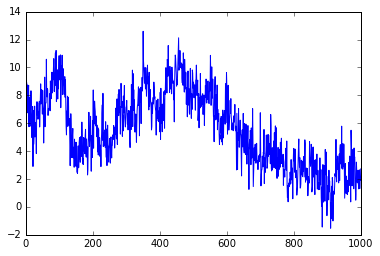

In [138]:
y[0].plot()

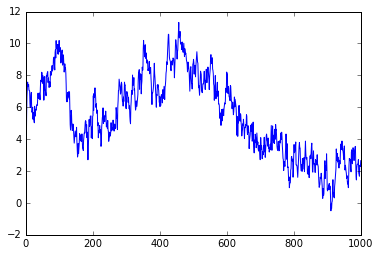

In [139]:
kf.yhat[0].plot()

## Timing the filter with and without Cython

In [140]:
# %%timeit -n 50
# kf = KalmanFilter(y,
#                   Z,
#                   H,
#                   T,
#                   Q,
#                   pd.DataFrame(np.array([0,0]).reshape(m,1)),
#                   pd.DataFrame(np.diag(np.array([1,1]))),
#                   R)

# kf.runFilter()

In [141]:
# import pyximport; pyximport.install()
# import KalmanFilter1

In [142]:
# %%timeit -n 50
# # COMPILED WITH CYTHON

# kf = KalmanFilter1.KalmanFilter(y,
#                   Z,
#                   H,
#                   T,
#                   Q,
#                   pd.DataFrame(np.array([0,0]).reshape(m,1)),
#                   pd.DataFrame(np.diag(np.array([1,1]))),
#                   R)

# kf.runFilter()

# Implementation for nulls

## Faster way to check for nulls Pandas or Numpy

In [143]:
ynp = np.array(y)

In [144]:
%%timeit -n 1000
y.isnull().any(axis=1)

1000 loops, best of 3: 244 µs per loop


In [145]:
%%timeit -n 1000
np.isnan(ynp).any(axis=1)

1000 loops, best of 3: 5.65 µs per loop


In [146]:
%%timeit -n 1000
y.isnull().all(axis=1)

1000 loops, best of 3: 249 µs per loop


In [147]:
%%timeit -n 1000
np.isnan(ynp).all(axis=1)

1000 loops, best of 3: 5.7 µs per loop


## Timing Implemention for whole line of nulls

In [153]:
class KalmanFilter():
#         """
#             Based on Durbin Koopman


#             For generic state-space systems like (Hamilton's notation):



#             $$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

#             $$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t}
#             \underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


#             $$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

#             Where

#             * $p$ is the number of observed variables
#             * $m$ is the number of latent states
#             * $r$ is the number of disturbances

#         """

    def __init__(self, y, Z, H, T, Q, a1, P1, R):
  
        
        self.yindex = y.index
        self.ycols = y.columns
        self.p = y.shape[1]
        self.n = y.shape[0]
        self.y = np.array(y)
        
        ind = np.zeros(self.y.shape[0])
        ind[np.isnan(self.y).any(axis=1)] = 1 # Some NaNs
        ind[np.isnan(self.y).all(axis=1)] = 2 # All NaNs
        self.ind = ind  
        
        self.yhat = []
        self.Z = np.array(Z)
        self.H = np.array(H)
        self.T = np.array(T)
        self.Q = np.array(Q)
        self.a = [np.array(a1)]
        self.P = [np.array(P1)]
        self.vt = []
        self.Ft = []
        self.Kt = []
        self.ZT = Z.T  # To avoid transposing it several times
        self.R = np.array(R)
        

    def runFilter(self, ):
        # Implemented with non time varying coefficients
        
        for i in range(0, self.n - 1):

            if self.ind[i] == 0:

                self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

                Finv = inv(self.Ft[i])

                self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

                self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))

                self.yhat.append(self.Z.dot(self.a[i]))
            
            elif self.ind[i] == 2: # In case the line is all nans
            
                self.vt.append(np.zeros((p,1)))
#                 self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

#                 Finv = inv(self.Ft[i])

#                 self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

#                 self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))
                
                self.yhat.append(self.Z.dot(self.a[i]))  
            
        self.a = pd.DataFrame(np.concatenate(self.a, axis=1)).T
        self.yhat = pd.DataFrame(np.concatenate(self.yhat, axis=1)).T

In [154]:
y.loc[20] = np.nan

In [155]:
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

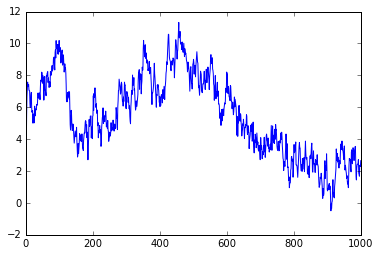

In [156]:
kf.yhat[0].plot()

In [28]:
# with many nulls
ny = y.copy()
ny.iloc[200:700] = np.nan

In [157]:
kf = KalmanFilter(ny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

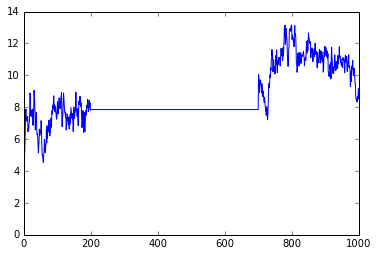

In [158]:
kf.yhat[0].plot()

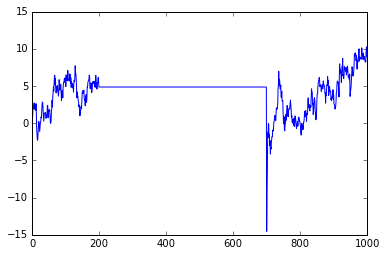

In [159]:
kf.a[0].plot()

In [160]:
%%timeit -n 50

kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

50 loops, best of 3: 160 ms per loop


In [107]:
%%timeit -n 50

kf = KalmanFilter(ny,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

50 loops, best of 3: 100 ms per loop


## Timing Implemention for partial line of nulls

### Fastest way to flat out 

In [31]:
yt = np.array([1,2,4,np.nan,5,6,7,np.nan,np.nan,8]).reshape((10,1))

In [32]:
yt[~np.isnan(yt)]

array([ 1.,  2.,  4.,  5.,  6.,  7.,  8.])

In [33]:
%%timeit -n 1000

~np.isnan(yt).reshape((10))

1000 loops, best of 3: 2.09 µs per loop


In [34]:
%%timeit -n 1000

np.array((~np.isnan(yt)).flat)

1000 loops, best of 3: 4.68 µs per loop


In [35]:
%%timeit -n 1000

(~np.isnan(yt)).ravel()

1000 loops, best of 3: 1.42 µs per loop


In [36]:
%%timeit -n 1000

(~np.isnan(yt)).flatten()

1000 loops, best of 3: 1.89 µs per loop


In [37]:
class KalmanFilter():
#         """
#             Based on Durbin Koopman


#             For generic state-space systems like (Hamilton's notation):



#             $$\underset{(p \times 1)}{y_t} = \underset{(p \times m)}{Z_t} \underset{(m \times 1)}{\alpha_t} + \underset{(p \times 1)}{\epsilon_t}, \qquad \epsilon_t \sim N(0,\underset{(p \times P)}{H_t}) $$

#             $$\underset{(m \times 1)}{\alpha_{t+1}} = \underset{(m \times m)}{T_t}
#             \underset{(m \times 1)}{\alpha_{t}} + \underset{(m \times r)}{R_t} \underset{(r \times r)}{\eta_t}, \qquad \eta_t \sim N(0,\underset{(r \times \ r)}{Q_t})$$


#             $$\alpha_1 \sim N(a_1,\underset{(m \times m)}{P_1})$$

#             Where

#             * $p$ is the number of observed variables
#             * $m$ is the number of latent states
#             * $r$ is the number of disturbances

#         """

    def __init__(self, y, Z, H, T, Q, a1, P1, R):
  
        
        self.yindex = y.index
        self.ycols = y.columns
        self.p = y.shape[1]
        self.n = y.shape[0]
        self.y = np.array(y)
        
        ind = np.zeros(self.y.shape[0])
        ind[np.isnan(self.y).any(axis=1)] = 1 # Some NaNs
        ind[np.isnan(self.y).all(axis=1)] = 2 # All NaNs
        self.ind = ind  
        
        self.yhat = []
        self.Z = np.array(Z)
        self.H = np.array(H)
        self.T = np.array(T)
        self.Q = np.array(Q)
        self.a = [np.array(a1)]
        self.P = [np.array(P1)]
        self.vt = []
        self.Ft = []
        self.Kt = []
        self.ZT = Z.T  # To avoid transposing it several times
        self.R = np.array(R)
        

    def runFilter(self, ):
        # Implemented with non time varying coefficients
        
        for i in range(0, self.n - 1):
            
            if self.ind[i] == 0:

                self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

                Finv = inv(self.Ft[i])

                self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

                self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))

                self.yhat.append(self.Z.dot(self.a[i]))
            
            elif self.ind[i] == 2: # In case the line is all nans
            
                self.vt.append(np.zeros((p,1)))
#                 self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(self.Z, self.a[i]))

                self.Ft.append(self.Z.dot(self.P[i]).dot(self.ZT) + self.H)

#                 Finv = inv(self.Ft[i])

#                 self.a[i] = self.a[i] + self.P[i].dot(self.ZT).dot(Finv).dot(self.vt[i])

#                 self.P[i] = self.P[i] - self.P[i].dot(self.ZT).dot(Finv).dot(self.Z).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))

                self.yhat.append(self.Z.dot(self.a[i]))  
            
            else:
                # First use an index for nulls
                ind = ~np.isnan(self.y[i]).ravel()
                yst = self.y[i][ind]
                Zst = self.Z[ind,:]
                
                select = np.diag(ind)
                select = select[(select==True).any(axis=1)].astype(int)

                Hst = select.dot(self.H).dot(select.T)
                
                
                self.vt.append(self.y[i].reshape((self.p, 1)) - np.dot(Zst, self.a[i]))

                self.Ft.append(Zst.dot(self.P[i]).dot(Zst) + Hst)

                Finv = inv(self.Ft[i])

                self.a[i] = self.a[i] + self.P[i].dot(Zst).dot(Finv).dot(self.vt[i])

                self.P[i] = self.P[i] - self.P[i].dot(Zst).dot(Finv).dot(Zst).dot(self.P[i])

                self.a.append(self.T.dot(self.a[i]))

                self.P.append(self.T.dot(self.P[i]).dot(self.T.T) + self.R.dot(self.Q).dot(self.R.T))
                
                yhat = np.empty((p,1))
                yhat[ind,:] = Zst.dot(self.a[i])
                yhat[~ind,:] = self.Z.dot(self.a[i])[~ind,:]
                
                self.yhat.append(yhat)
                
                
            
        self.a = pd.DataFrame(np.concatenate(self.a, axis=1)).T
        self.yhat = pd.DataFrame(np.concatenate(self.yhat, axis=1)).T

In [38]:
kf = KalmanFilter(y,
                  Z,
                  H,
                  T,
                  Q,
                  pd.DataFrame(np.array([0,0]).reshape(m,1)),
                  pd.DataFrame(np.diag(np.array([1,1]))),
                  R)

kf.runFilter()

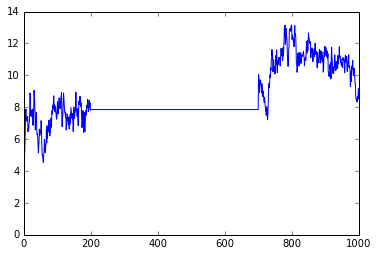

In [40]:
kf.yhat[0].plot()